# Notebook for Explosive Production Chemical Reaction Network

Explosive production chemical reaction: $S \xrightarrow{\theta} 2S$.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import torch
import matplotlib.pyplot as plt

import neuralnetwork
import convert_csv
import plot
import save_load_MDN

from scipy.stats import nbinom
from scipy.special import comb

from CRN3_explosive_production import propensities_explosive_production as propensities

## Import data

In [2]:
FILE_NAME = 'data'
CRN_NAME = 'explosive_production'
NUM_PARAMS = 1

In [3]:
# loading data
X_train1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train1.csv')
X_train2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train2.csv')
X_train3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_train3.csv')
y_train1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train1.csv')
y_train2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train2.csv')
y_train3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_train3.csv')
X_valid1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid1.csv')
X_valid2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid2.csv')
X_valid3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_valid3.csv')
y_valid1 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid1.csv')
y_valid2 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid2.csv')
y_valid3 = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_valid3.csv')
X_test = convert_csv.csv_to_tensor(f'{FILE_NAME}/X_{CRN_NAME}_test.csv')
y_test = convert_csv.csv_to_tensor(f'{FILE_NAME}/y_{CRN_NAME}_test.csv')

train_data1 = [X_train1, y_train1]
valid_data1 = [X_valid1, y_valid1]
train_data2 = [X_train2, y_train2]
valid_data2 = [X_valid2, y_valid2]
train_data3 = [X_train3, y_train3]
valid_data3 = [X_valid3, y_valid3]

INIT_STATE = 5

## Hyperparameters

In [4]:
LR = 0.001
BATCHSIZE = 32
N_ITER = 300
N_HIDDEN = 256
MIXTURE = 'NB'

## Choosing number of components

Computed loss with 1 components - average loss = 0.3333333333333333.
Computed loss with 2 components - average loss = 0.05752280354499817.
Computed loss with 3 components - average loss = 0.05762122571468353.
Computed loss with 4 components - average loss = 0.056904549400011696.
Computed loss with 5 components - average loss = 0.056679035226504006.
Computed loss with 6 components - average loss = 0.056658342480659485.


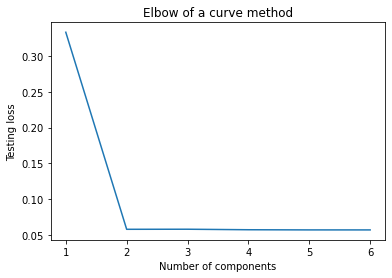

In [5]:
n_comps = np.arange(1, 7)
losses = []
for n in n_comps:
    loss = 0
    for _ in range(3):
        model = neuralnetwork.NeuralNetwork(n_comps=n, n_params=NUM_PARAMS, n_hidden=N_HIDDEN, mixture=MIXTURE, print_info=False)
        neuralnetwork.train_NN(model, train_data1, valid_data1, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE, print_results=False, print_info=False)
    loss += neuralnetwork.mean_loss(X_test, y_test, model, loss=neuralnetwork.loss_hellinger).detach().item()
    losses.append(loss/3)
    print(f'Computed loss with {n} components - average loss = {loss/3}.')
plt.plot(n_comps, losses)
plt.xlabel('Number of components')
plt.ylabel('Testing loss')
plt.title('Elbow of a curve method')
plt.show()

In [5]:
N_COMPS = 4

## Training models

We train 3 different models to compare their accuracy.

In [7]:
model1 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, mixture=MIXTURE)
model2 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, mixture=MIXTURE)
model3 = neuralnetwork.NeuralNetwork(n_comps=N_COMPS, n_params=NUM_PARAMS, mixture=MIXTURE)

Mixture Density Network created.
Mixture Density Network created.
Mixture Density Network created.


In [8]:
train_losses1, valid_losses1 = neuralnetwork.train_NN(model1, train_data1, valid_data1, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)
train_losses2, valid_losses2 = neuralnetwork.train_NN(model2, train_data2, valid_data2, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)
train_losses3, valid_losses3 = neuralnetwork.train_NN(model3, train_data3, valid_data3, loss=neuralnetwork.loss_kldivergence, max_rounds=N_ITER, lr=LR, batchsize=BATCHSIZE)

Training ...: 100%|█████████▉| 299/300 [13:44<00:02,  2.76s/it]


Learning rate: 2.741531724392847e-08,
Train loss: 0.16052459180355072,
 Valid loss: 0.16603021323680878


Training ...: 100%|█████████▉| 299/300 [13:12<00:02,  2.65s/it]


Learning rate: 2.741531724392847e-08,
Train loss: 0.16154633462429047,
 Valid loss: 0.1671578586101532


Training ...: 100%|█████████▉| 299/300 [13:03<00:02,  2.62s/it]

Learning rate: 2.741531724392847e-08,
Train loss: 0.15941821038722992,
 Valid loss: 0.16123823821544647


In [9]:
for i, model in enumerate([model1, model2, model3]):
    save_load_MDN.save_MDN_model(model, f'CRN3_model{i+1}_comps4.pt')

In [6]:
model1 = save_load_MDN.load_MDN_model('CRN3_model1_comps4.pt')
model2 = save_load_MDN.load_MDN_model('CRN3_model2_comps4.pt')
model3 = save_load_MDN.load_MDN_model('CRN3_model3_comps4.pt')

Mixture Density Network created.
Mixture Density Network created.
Mixture Density Network created.


In [10]:
# Compute losses

print("Training dataset")
print(f"KLD : {neuralnetwork.mean_loss(X_train3, y_train3, model3, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_train3, y_train3, model3, loss=neuralnetwork.loss_hellinger)}')

print("\nValidation dataset")
print(f"KLD : {neuralnetwork.mean_loss(X_valid3, y_valid3, model3, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_valid3, y_valid3, model3, loss=neuralnetwork.loss_hellinger)}')

print("\nTest dataset")
print(f"KLD : {neuralnetwork.mean_loss(X_test, y_test, model3, loss=neuralnetwork.loss_kldivergence)}")
print(f'Hellinger : {neuralnetwork.mean_loss(X_test, y_test, model3, loss=neuralnetwork.loss_hellinger)}')


Training dataset
KLD : 0.15941821038722992
Hellinger : 0.171232670545578

Validation dataset
KLD : 0.16123823821544647
Hellinger : 0.17048227787017822

Test dataset
KLD : 0.15880624949932098
Hellinger : 0.171052023768425


## Distributions plot

To compare predicted distributions to the theoretical ones. Given an initial condition r = 5, the population of $S$ at any later time is a random integer sampled from a Negative Binomial distribution:
$$f(x, t, \theta) = \binom{k + r - 1}{r-1} (1-e^{-t\theta})^k(e^{-t\theta})^r$$


In [7]:
def explosive_production_distribution(x, params, r=INIT_STATE):
    if x < r:
        return 0
    else:
        t, theta = params
        return nbinom.pmf(x-r, r, np.exp(-t*theta))

In [8]:
NAME = 'Explosive Production CRN'

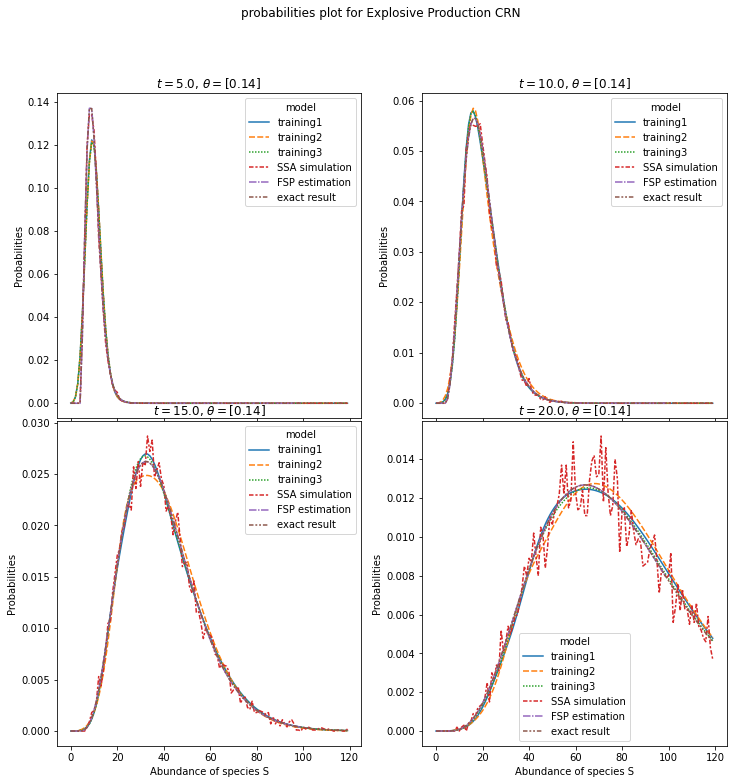

In [9]:
plot.multiple_plots(to_pred=[X_test[992+k,:] for k in range(4)], 
                models=[model1, model2, model3], 
                up_bound=[120]*4, 
                n_comps=N_COMPS,
                plot_exact_result=(True, explosive_production_distribution),
                plot_test_result=(True, [y_test[992+k, :] for k in range(4)]),
                plot_fsp_result=(True, np.expand_dims(propensities.stoich_mat, axis=0), propensities.propensities, 100, propensities.init_state, 0),
                save=(False, '4distributions.png'),
                crn_name=NAME)

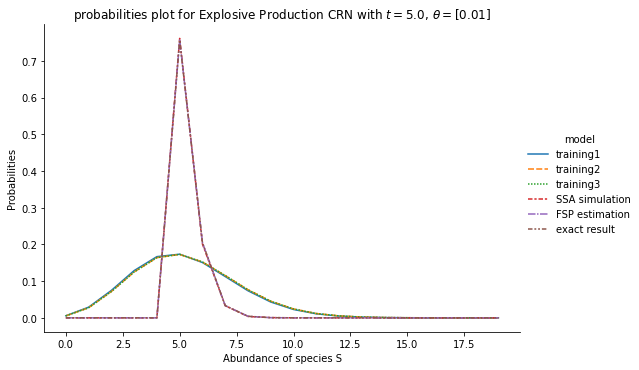

In [10]:
index = 100
plot.plot_model(to_pred=X_test[index,:], 
                models=[model1, model2, model3], 
                up_bound=20, 
                n_comps=N_COMPS,
                plot_exact_result=(True, explosive_production_distribution),
                plot_test_result = (True, y_test[index, :]),
                plot_fsp_result=(True, np.expand_dims(propensities.stoich_mat, axis=0), propensities.propensities, 100, propensities.init_state, 0), 
                save=(False, 'interesting.png'),
                crn_name=NAME)

We can check the accuracy for higher times than those of the traning:

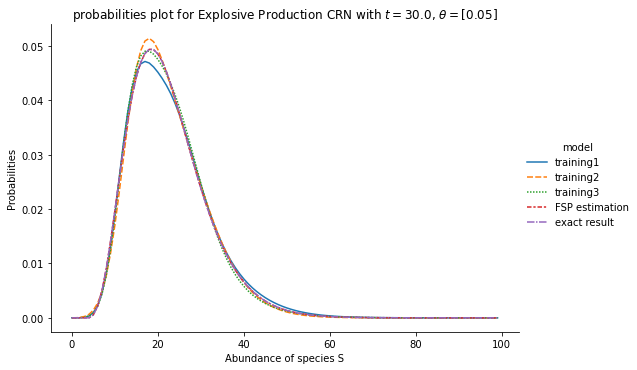

In [11]:
plot.plot_model(to_pred=torch.tensor([30., 0.05]), 
                models=[model1, model2, model3], 
                up_bound = 100, 
                n_comps=N_COMPS,
                plot_exact_result=(True, explosive_production_distribution),
                plot_fsp_result=(True, np.expand_dims(propensities.stoich_mat, axis=0), propensities.propensities, 100, propensities.init_state, 0),
                confidence_interval=False, 
                save=(False, "t30c005.png"),
                crn_name=NAME)

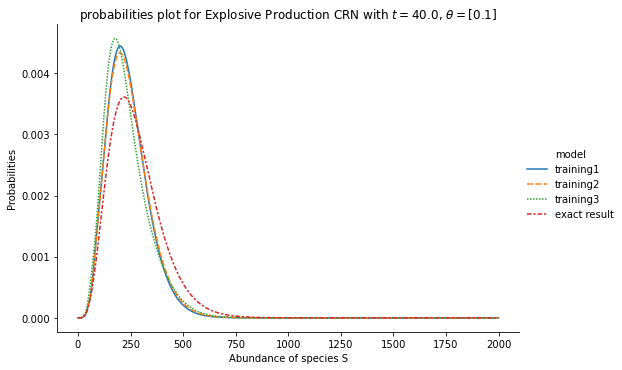

In [16]:
plot.plot_model(to_pred=torch.tensor([40., 0.1]), 
                models=[model1, model2, model3], 
                up_bound = 2000, 
                n_comps=N_COMPS,
                plot_exact_result=(True, explosive_production_distribution),
                save=(False, 'interesting2.png'),
                crn_name=NAME)

We can also check the accuracy for parameters outside the bounds of the training.

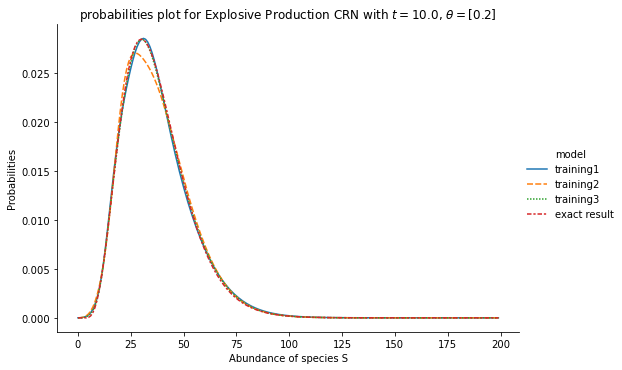

In [17]:
plot.plot_model(to_pred=torch.tensor([10., 0.2]), 
                models=[model1, model2, model3], 
                up_bound = 200, 
                n_comps=N_COMPS,
                plot_exact_result=(True, explosive_production_distribution),
                confidence_interval=False, 
                save=(False, 'distribution_t10c02.png'),
                crn_name=NAME)

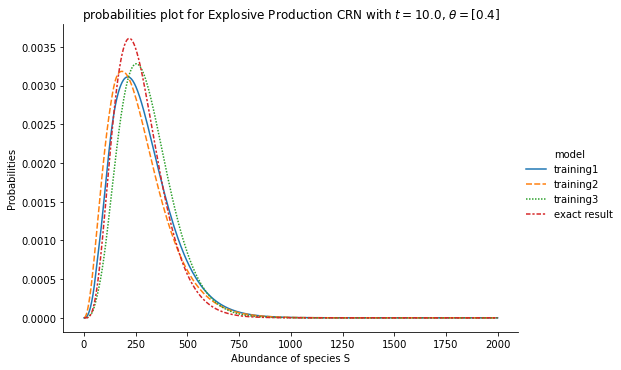

In [18]:
plot.plot_model(to_pred=torch.tensor([10., 0.4]), 
                models=[model1, model2, model3], 
                up_bound = 2000,
                n_comps=N_COMPS,
                plot_exact_result=(True, explosive_production_distribution),
                crn_name=NAME)

## Sensitivities plot

To compute sensitivities and compare them to the theoretical ones.

$$\nabla_\theta  f(k, r, \theta , t) = \binom{k+r-1}{r-1} e^{-\theta tr}(1-e^{-\theta t})^{k-1}t(ke^{-\theta t}-(1-e^{-\theta t})r)$$

In [12]:
def explosive_production_stv(k, params, r=INIT_STATE):
    if k < r:
        return 0
    else:
        t, theta = params
        return comb(k-1, r-1) * np.exp(-theta*t*r) * (1-np.exp(-theta*t))**(k-r-1) * t * ((k-r)*np.exp(-theta*t) - (1-np.exp(-theta*t))*r)

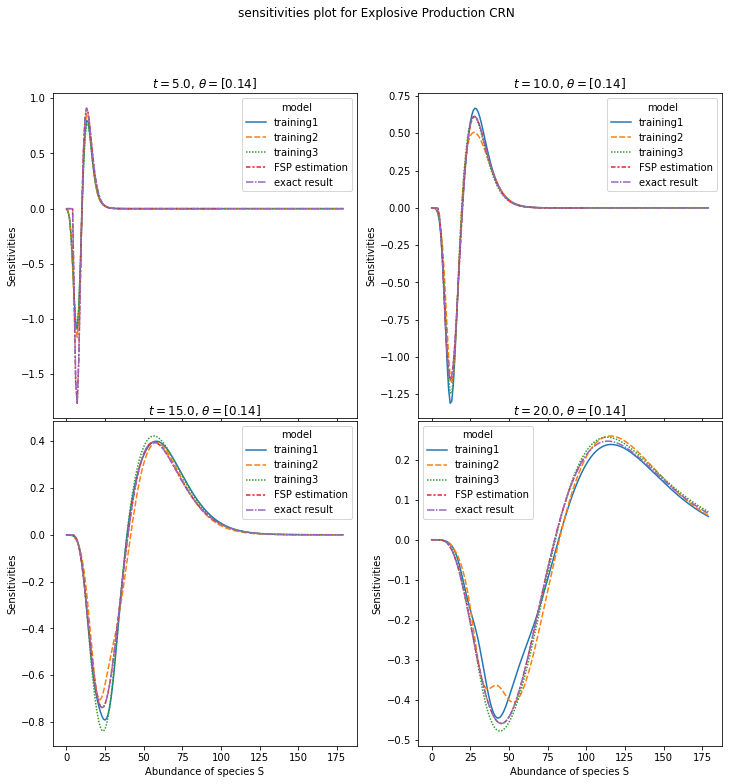

In [13]:
plot.multiple_plots(to_pred=[X_test[992+k,:] for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = [180]*4, 
                    n_comps=N_COMPS,
                    plot_exact_result=(True, explosive_production_stv),
                    plot_fsp_result=(True, np.expand_dims(propensities.stoich_mat, axis=0), propensities.propensities, 100, propensities.init_state, 0), 
                    index_names = ('Sensitivities', 'Abundance of species S'), 
                    plot=('sensitivities', 0), 
                    save=(False, 'sensitivities_4distributions.png'),
                    crn_name=NAME)

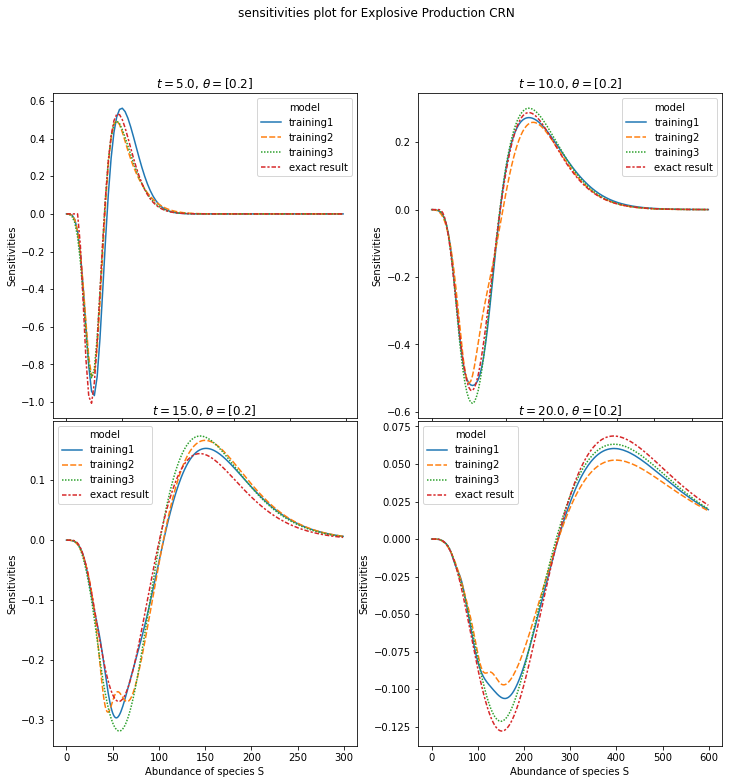

In [23]:
plot.multiple_plots(to_pred=[torch.tensor([5*(k+1), 0.2]) for k in range(4)], 
                    models=[model1, model2, model3], 
                    up_bound = [100, 150, 300, 600], 
                    n_comps=N_COMPS,
                    plot_exact_result=(True, explosive_production_stv),
                    index_names = ('Sensitivities', 'Abundance of species S'), 
                    plot=('sensitivities', 0), 
                    save=(False, 'sensitivities_4distributions.png'),
                    crn_name=NAME)

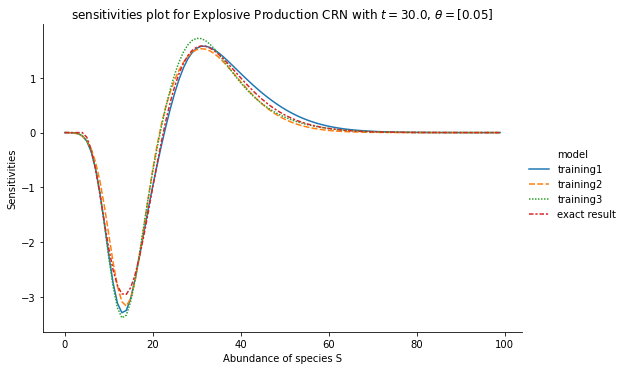

In [24]:
plot.plot_model(to_pred=torch.tensor([30., 0.05]), 
                models=[model1, model2, model3], 
                up_bound=100, 
                n_comps=N_COMPS,
                plot_exact_result=(True, explosive_production_stv),
                index_names = ('Sensitivities', 'Abundance of species S'), 
                plot=('sensitivities', 0), 
                save=(False, 'sensitivities_t30c005.png'),
                crn_name=NAME)

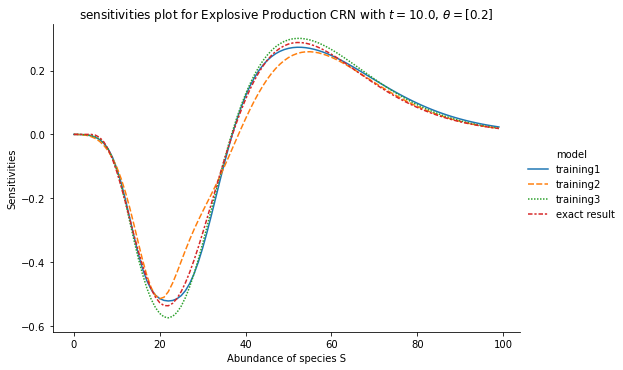

In [25]:
plot.plot_model(to_pred=torch.tensor([10., 0.2]), 
                models=[model1, model2, model3], 
                up_bound=100, 
                n_comps=N_COMPS,
                plot_exact_result=(True, explosive_production_stv),
                index_names = ('Sensitivities', 'Abundance of species S'), 
                plot=('sensitivities', 0), 
                save=(False, 'sensitivities_t10c02.png'),
                crn_name=NAME)

## Fisher Information

In [14]:
def exact_fi(t, params, r=INIT_STATE, up_bound=1_000):
    theta = params[0]
    res = 0
    for k in range(up_bound):
        if explosive_production_distribution(k, [t]+params, r):
            res += explosive_production_stv(k, [t]+params, r)**2/explosive_production_distribution(k, [t]+params, r)
    return res

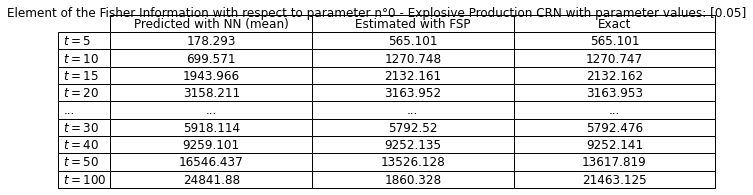

In [23]:
plot.fi_table(time_samples=[5, 10, 15, 20, 30, 40, 50, 100], 
            params=[0.05], 
            ind_param=0, 
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_exact=(True, exact_fi),
            up_bound=1_000,
            plot_fsp=(True, np.expand_dims(propensities.stoich_mat, axis=0), propensities.propensities, 200, propensities.init_state, 0),
            crn_name=NAME,
            out_of_bounds_index=4)

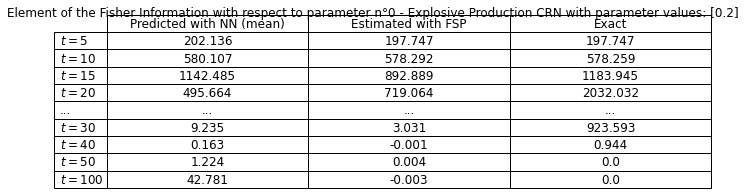

In [22]:
plot.fi_table(time_samples=[5, 10, 15, 20, 30, 40, 50, 100], 
            params=[0.2], 
            ind_param=0, 
            models=(True, [model1, model2, model3], N_COMPS), 
            plot_exact=(True, exact_fi),
            up_bound=200,
            plot_fsp=(True,  np.expand_dims(propensities.stoich_mat, axis=0), propensities.propensities, 200, propensities.init_state, 0),
            crn_name=NAME,
            out_of_bounds_index=4)